# What's so great about linear models?

Linear models are a mainstay of statistical analysis for a reason. Often when I need more complex models to explain a response, I still start with a linear model to ensure my inferences from other models are on a firm footing.

This is because the most valuable qualities of linear models make them a useful starting point, and sometimes the end point too:
* Simplicity: restrictive and yet versatile
* Interpretability: no black boxes here
* Extensibility: building complexity as needed

---------------------

## Simplicity: restrictive and yet versatile

In its simplest form, we must assume:
* The response values were observed independently
* The error term is a normal distribution with constant variance
* The model is linear in the coefficients, such that...
* _A change in the response can be explained as a linear function of changes in its predictors_

The stringent set of assumptions and properties allow us to:
1. Estimate effect sizes that we can easily understand
2. Test our hypotheses about how the predictors explain variation in the response
3. Predict new response values based on new predictor observations
4. Infer causal relationships, _if the data and our domain knowledge permit it_

To achieve the goals listed above – especially goals 1, 2 and 4 – we need to be able to **interpret and interrogate** our model clearly, and to **avoid violating model assumptions by transforming the data or model** in ways that don't wholly cost us our interpretation.

I'll demonstrate these two things using an example.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import statsmodels.api as sm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
mpg = sns.load_dataset('mpg')
mpg.drop(mpg[mpg.horsepower.isnull()].index, inplace=True)

----------------------------

## Interpretability

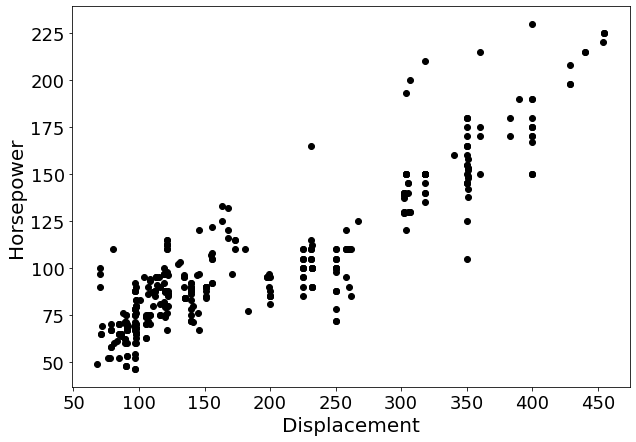

In [89]:
plt.figure(figsize=(10,7))
plt.scatter(mpg.displacement[:,np.newaxis], mpg.horsepower[:,np.newaxis], color='black')
plt.xlabel('Displacement', fontsize=20)
plt.ylabel('Horsepower', fontsize=20)
plt.tick_params(axis='both', which='both', labelsize=18)
plt.show()

Fit a linear model to these data and then fit a nonlinear, nonparametric alternative for comparison.

In [4]:
lm = LinearRegression()
lm_fit = lm.fit(mpg.displacement[:,np.newaxis], mpg.horsepower[:,np.newaxis])

In [90]:
svr = SVR(kernel='rbf', C=50, gamma='scale', epsilon=.1, degree=3, shrinking=False)
svr_fit = svr.fit(mpg.displacement[:,np.newaxis], mpg.horsepower.ravel())

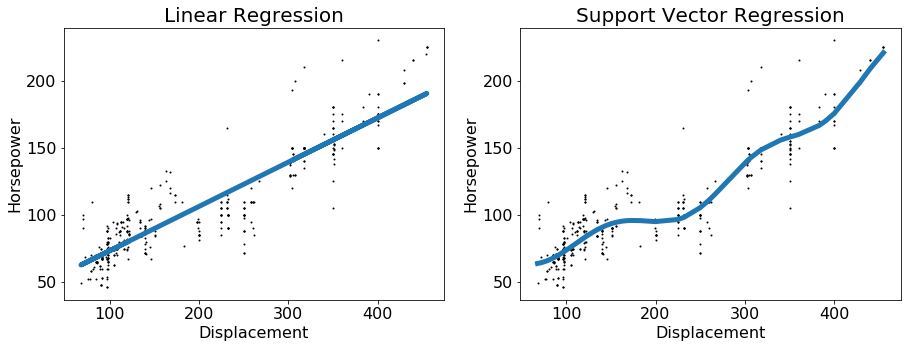

In [91]:
fig,(a1,a2) = plt.subplots(ncols=2, figsize=(15,5))

a1.scatter(mpg.displacement[:,np.newaxis], mpg.horsepower[:,np.newaxis], color='black', s=1)
a1.plot(mpg.displacement[:,np.newaxis], lm.predict(mpg.displacement[:,np.newaxis]), linewidth=5)
a1.set_title('Linear Regression')
a1.title.set_fontsize(20)
a1.tick_params(axis='both', which='both', labelsize=16)
a1.set_xlabel('Displacement', fontsize=16)
a1.set_ylabel('Horsepower', fontsize=16)

i = np.argsort(mpg.displacement)
a2.scatter(mpg.displacement[:,np.newaxis], mpg.horsepower[:,np.newaxis], color='black', s=1)
a2.plot(mpg.displacement[i,np.newaxis], svr.predict(mpg.displacement[i,np.newaxis]), linewidth=5)
a2.set_title('Support Vector Regression')
a2.title.set_fontsize(20)
a2.tick_params(axis='both', which='both', labelsize=16)
a2.set_xlabel('Displacement', fontsize=16)
a2.set_ylabel('Horsepower', fontsize=16)

plt.show()

The simplicity of the linear model means that the effect of `Displacement` on `Horsepower` is global, i.e. not dependent on the value of `Displacement`, which makes our job of interpreting the model much easier.

In [7]:
lm_fit.coef_ * 100

array([[33.00376655]])

If we compare cars A and B, where car B has a `Displacement` volume of 100 more units than car A, then we expect car B's horsepower to be 33 units greater than car A.

Making similar interpretations from the support vector regression is not so simple.

In the same way, diagnosing problems with the model fit by looking at residual plots and the effects of predictors is easier to do with simpler models like the linear regression.

-------------------------

## Extensibility

We can add model flexibility while keeping within the linear model framework in various ways, for example:
* Use glms to assume the responses are drawn from a different distribution
* Use random effects to model the variability
* Use shrinkage methods to deal with problems of collinearity and sparsity
* Use nonparametric methods like smoothing splines in the linear predictor

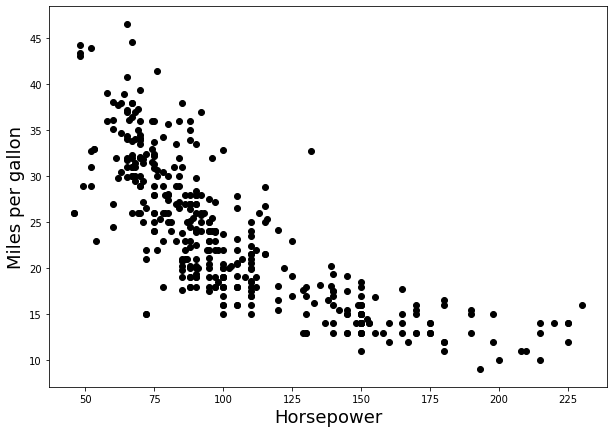

In [9]:
plt.figure(figsize=(10,7))
plt.scatter(x=mpg.horsepower[:,np.newaxis], y=mpg.mpg[:,np.newaxis], color='black')
plt.xlabel('Horsepower', fontsize=18)
plt.ylabel('Miles per gallon', fontsize=18)
plt.show()

Cars with lower horsepower appear to have much higher miles per gallon than mid-range or high horsepower cars. Also, variation in miles per gallon is greater at higher values. Based on these observations, we might improve upon the linear model by relaxing certain assumptions.

My choice here is to assume the response values are drawn from a Gamma distribution and model the response as a function of its predictors on the log scale, i.e. log link function. Then, on the linear predictor scale we might have a simpler relationship to explain.

In [85]:
X = sm.add_constant(mpg.horsepower)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
glm = sm.GLM(mpg.mpg, X, family=sm.families.Gamma(sm.families.links.log))
glm_fit = glm.fit()

In [81]:
X_pred = pd.DataFrame({'horsepower': np.linspace(np.min(mpg.horsepower), np.max(mpg.horsepower), 50)})
X_pred = sm.add_constant(X_pred)

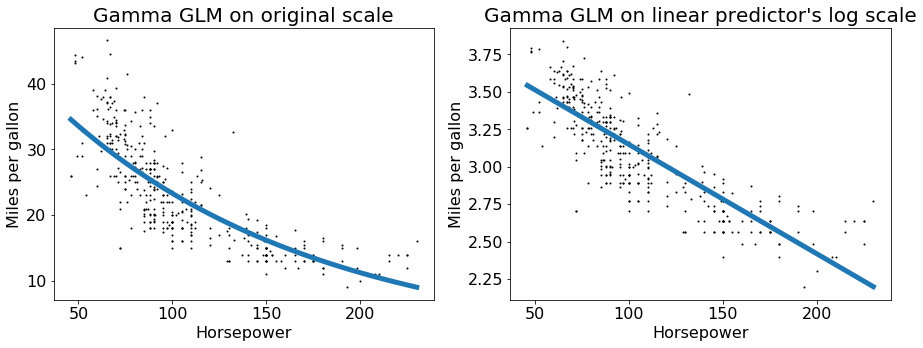

In [92]:
fig,(a1,a2) = plt.subplots(ncols=2, figsize=(15,5))

a1.scatter(mpg.horsepower[:,np.newaxis], mpg.mpg[:,np.newaxis], color='black', s=1)
a1.plot(X_pred.horsepower[:,np.newaxis], glm_fit.predict(X_pred, linear=False), linewidth=5)
a1.set_title('Gamma GLM on original scale')
a1.title.set_fontsize(20)
a1.tick_params(axis='both', which='both', labelsize=16)
a1.set_xlabel('Horsepower', fontsize=16)
a1.set_ylabel('Miles per gallon', fontsize=16)

a2.scatter(mpg.horsepower[:,np.newaxis], np.log(mpg.mpg[:,np.newaxis]), color='black', s=1)
a2.plot(X_pred.horsepower[:,np.newaxis], glm_fit.predict(X_pred, linear=True), linewidth=5)
a2.set_title("Gamma GLM on linear predictor's log scale")
a2.title.set_fontsize(20)
a2.tick_params(axis='both', which='both', labelsize=16)
a2.set_xlabel('Horsepower', fontsize=16)
a2.set_ylabel('Miles per gallon', fontsize=16)

plt.show()

-----------------

## Closing remarks

These features of linear models don't make other models redundant. Even black-box models can be extremely useful, especially when making predictions.

Also, as we extend linear models in various ways to add flexibility, we are often sacrificing some interpretability. So we can't necessarily have our cake and eat it too.

But, understanding linear models is fundamental to understanding other more complex models too. And this is why I could not do without them.